# Practical session 1
>  - María Castro
>  - Jorge Martín
>  - Miguel Angel Rojas


## Import library

In [19]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas_profiling
from datetime import datetime


## Functions

In [20]:
def read(file_name, fheader, fletter, ftrial):
   # global fdata2
    fsadl1 = pd.read_csv(file_name, sep=';', decimal=',', names=fheader)
   
    fsadl1['muestra'] = fletter
    #fsadl1['trial'] = ftrial
    fdata = fsadl1.iloc[:, :96] 
    
    # Merge them
    
    
    flabels = fsadl1['muestra']
    ## Preprocessing data
    #find and remove rows with all nulls
    fidx=fdata.index[fdata.isnull().all(1)] #1 is the axis for rows
    #select data not in idx, that is data that is not all null
    fdata = fdata[~fdata.index.isin(fidx)] 
    #same for labels
    flabels = flabels[~flabels.index.isin(fidx)]

    flabels.value_counts()


    #fill missing values
    fdata = fdata.fillna(method='ffill',axis=1)
    
    return fdata, flabels


In [21]:
def num_to_letter(number):
    switcher = {
        1: "A",
        2: "C",
        3: "L",
        4: "M",
        5: "O",
        6: "U"
    }
    return switcher.get(number, "Invalid month")

In [23]:
#separate train and test train_test_split function' 
def train_test_split_local(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    train_test_split(y, shuffle=False)
    return X_train, X_test, y_train, y_test

In [24]:
def plot_confusion_matrix(cm, names, title='MATRIZ DE CONFUSIÓN', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('Clase real')
    plt.xlabel('Clase predicha')

In [27]:
def windowing(fdata, window_number, window_text, porcentage, flabels, frol):

    for ind in range(0,len(fdata.index)):
        resta= fdata.fecha[ind] - fdata.fecha[0]
        fdata.MILLISEC[ind] =  resta.total_seconds()*1000

    columns = fdata.columns[~fdata.columns.isin(['muestra', 'fecha','MILLISEC'])]
    
    ffiltered_data = fdata[columns].rolling(frol).median()
    ffiltered_data['MILLISEC'] = fdata.MILLISEC    

    # Windowing and Feature Extraction
    ffiltered_data['time']=pd.to_datetime(fdata.MILLISEC,unit='ms')    
    ffiltered_data.index=ffiltered_data.time
    
    
    #calculate mean over a 1 second window
    keep = ffiltered_data.time.dt.microsecond/window_number %porcentage
    keep = keep - keep.shift() < 0

  
    ffiltered_data.sort_index()
    means = ffiltered_data[columns].rolling(window_text).mean()[keep]
    means.columns = [str(col) + '_mean' for col in means.columns]
    variances = ffiltered_data[columns].rolling(window_text).var()[keep]
    variances.columns = [str(col) + '_var' for col in variances.columns]

    #talk about apply function
    flabels.index = ffiltered_data.time
    mode_labels = flabels.rolling(window_text).apply(lambda x:mode(x)[0])[keep]

    #all features
    fall_features = pd.concat([means, variances],axis=1)
    fall_features['muestra'] = mode_labels
    #fall_features['user'] = user
    #fall_features['trial'] = trial
    
    return fall_features

## Execises definitions and clasifiers


In [28]:
def excercise_1 (fall_data, estimators):
    # Exercise 1
    # Random train test split

    # Labels are the values we want to predict
    labels = np.array(fall_data['muestra'])

    # Remove the labels from the features
    # axis 1 refers to the columns
    features = fall_data.drop('muestra', axis = 1)
    features = features.drop('fecha', axis = 1)
    features = features.drop('vacio', axis = 1)


    # Saving feature names for later use
    feature_list = list(features.columns)

    # Convert to numpy array
    features = np.array(features)


    X_train, X_test, y_train, y_test = train_test_split_local(features, labels)

    print('X_train:', X_train.shape)
    print('X_test:', X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:', y_test.shape)


    classifier = RandomForestClassifier(n_estimators=estimators, random_state=0)  
    classifier.fit(X_train, y_train)  
    y_pred = classifier.predict(X_test)
    
    labels = ["A","C","L","M","O","U"]

    print("\n _______________________________________________________")  
    print("confusion matrix: \n")  
    print(confusion_matrix(y_test,y_pred))  
    print("\n _______________________________________________________")  
    print("classification report: \n")  
    print(classification_report(y_test,y_pred))  
    print("_______________________________________________________")  
    print("accuracy score: " + str(accuracy_score(y_test, y_pred)))  

    
    plt.figure(figsize=(15,8))
    plot_confusion_matrix(confusion_matrix(y_test,y_pred), labels)

def excercise_2 (fall_data, estimators):
    # Excercise 2
    # user 1 2 3 train test 4

    # Labels are the values we want to predict
    # Remove the labels from the features
    # axis 1 refers to the columns

    user123 = fall_data[fall_data['user'].isin([1, 2, 3])]
    user4 = fall_data[fall_data['user'].isin([4])]


    y_train_2 = np.array(user123['label'])
    y_test_2 = np.array(user4['label'])

    user123 = user123.drop('label', axis = 1)
    user123 = user123.drop('user', axis = 1)
    user123 = user123.drop('trial', axis = 1)

    user4 = user4.drop('label', axis = 1)
    user4 = user4.drop('user', axis = 1)
    user4 = user4.drop('trial', axis = 1)

    X_train_2 = np.array(user123)
    X_test_2 = np.array(user4)
    print('X_train_2:', X_train_2.shape)
    print('X_test_2:', X_test_2.shape)
    print('y_train_2:', y_train_2.shape)
    print('y_test_2:', y_test_2.shape)


    classifier2 = RandomForestClassifier(n_estimators=estimators, random_state=0)  
    classifier2.fit(X_train_2, y_train_2)  
    y_pred_2 = classifier2.predict(X_test_2)

    print("\n _______________________________________________________")  
    print("confusion matrix: \n")  
    print(confusion_matrix(y_test_2,y_pred_2))  
    print("\n _______________________________________________________")  
    print("classification report: \n")  
    print(classification_report(y_test_2,y_pred_2))  
    print("_______________________________________________________")  
    print("accuracy score: " +str(accuracy_score(y_test_2, y_pred_2)))

    labels = [0,1,2,4,5]
    plt.figure(figsize=(15,8))
    plot_confusion_matrix(confusion_matrix(y_test_2,y_pred_2), labels)

def excercise_3 (fall_data, estimators):  
    # Excercise 3
    #  1,2,3 and drill session as training data and trials 4 and 5 as test data.

    # Labels are the values we want to predict
    # Remove the labels from the features
    # axis 1 refers to the columns

    trial1236 = fall_data[fall_data['trial'].isin([1, 2, 3, 6])]
    trial45 = fall_data[fall_data['trial'].isin([4, 5])]

    y_train_3 = np.array(trial1236['label'])
    y_test_3 = np.array(trial45['label'])

    trial1236 = trial1236.drop('label', axis = 1)
    trial1236 = trial1236.drop('user', axis = 1)
    trial1236 = trial1236.drop('trial', axis = 1)

    trial45 = trial45.drop('label', axis = 1)
    trial45 = trial45.drop('user', axis = 1)
    trial45 = trial45.drop('trial', axis = 1)

    X_train_3 = np.array(trial1236)
    X_test_3 = np.array(trial45)

    print('X_train_3:', X_train_3.shape)
    print('X_test_3:', X_test_3.shape)
    print('y_train_3:', y_train_3.shape)
    print('y_test_3:', y_test_3.shape)


    classifier = RandomForestClassifier(n_estimators=estimators, random_state=0)  
    classifier.fit(X_train_3, y_train_3)  
    y_pred_3 = classifier.predict(X_test_3)


    print("\n _______________________________________________________")  
    print("confusion matrix: \n")  
    print(confusion_matrix(y_test_3,y_pred_3))  
    print("\n _______________________________________________________")  
    print("classification report: \n")  
    print(classification_report(y_test_3,y_pred_3))  
    print("_______________________________________________________")  
    print("accuracy score: " + str(accuracy_score(y_test_3, y_pred_3)))

    labels = [0,1,2,4,5]
    plt.figure(figsize=(15,8))
    plot_confusion_matrix(confusion_matrix(y_test_3,y_pred_3), labels)

## Read data

In [33]:

path = 'dataset-proyecto/' #enter thepath for the dataset folder
header_path = 'header-proy.csv' #enter the path for the header file
header=pd.read_csv(header_path,names=['column',''],sep=';', decimal=',')['column'].values
num_letters = range(1,7) #7
trials = range(1,2) #6
users=range(2,6) #6


In [34]:
all_data_1S = pd.DataFrame()

for num_letter in num_letters:
    letter = num_to_letter(num_letter)
    for user in users:
        for trial in trials:
            file_name = path+str(letter)+'-'+str(user)+'-'+str(trial)+'.csv'
            data, labels = read(file_name, header, num_letter, trial)
            data['fecha'] = pd.to_datetime(data['fecha'], format='%H.%M.%S.%f', errors='ignore')
            
            data.loc[:,'MILLISEC':] = data.loc[:,'MILLISEC':].apply(pd.to_numeric, errors='coerce')
            
            
            
            all_features_1S = windowing(data, 1000, '1S', 500, labels, 59)
            all_data_1S = pd.concat([all_data_1S, all_features_1S])
       
        #we use a window of 11 elements
        # Filtering using median filter
        
        #all_features_1S = windowing(data, 1000, '1S', 500, labels, 11)
        #all_data_1S = pd.concat([all_data_1S, all_features_1S])
#data=data.drop(['x','x.1','x.2','x.3','x.4','x.5','x.6','x.7','x.8','x.9','x.10','x.11','x.12','x.13','x.14'], axis = 1)


/home/ubuntu/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pandas/io/parsers.py:709: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)
/home/ubuntu/anaconda3/envs/machine_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/ubuntu/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pandas/io/parsers.py:709: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)
/home/ubuntu/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pandas/io/parsers.py:709: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)
/home/ubuntu/anaconda3

In [14]:
print(labels)

time
1970-01-01 00:00:00.000000    1
1970-01-01 00:00:00.146917    1
1970-01-01 00:00:00.156909    1
1970-01-01 00:00:00.184893    1
1970-01-01 00:00:00.195888    1
1970-01-01 00:00:00.197887    1
1970-01-01 00:00:00.200887    1
1970-01-01 00:00:00.203883    1
1970-01-01 00:00:00.225871    1
1970-01-01 00:00:00.333706    1
1970-01-01 00:00:00.336704    1
1970-01-01 00:00:00.339706    1
1970-01-01 00:00:00.342702    1
1970-01-01 00:00:00.346699    1
1970-01-01 00:00:00.359692    1
1970-01-01 00:00:00.376682    1
1970-01-01 00:00:00.392672    1
1970-01-01 00:00:00.409663    1
1970-01-01 00:00:00.426309    1
1970-01-01 00:00:00.443279    1
1970-01-01 00:00:00.459268    1
1970-01-01 00:00:00.477262    1
1970-01-01 00:00:00.493249    1
1970-01-01 00:00:00.510244    1
1970-01-01 00:00:00.527230    1
1970-01-01 00:00:00.543220    1
1970-01-01 00:00:00.559210    1
1970-01-01 00:00:00.577202    1
1970-01-01 00:00:00.593192    1
1970-01-01 00:00:00.609182    1
                             ..
197

In [15]:
all_data_1S.dtypes

ref x_mean      float64
ref y_mean      float64
ref z_mean      float64
x_mean          float64
y_mean          float64
z_mean          float64
ro_mean         float64
theta_mean      float64
phi_mean        float64
x.1_mean        float64
y.1_mean        float64
z.1_mean        float64
ro.1_mean       float64
theta.1_mean    float64
phi.1_mean      float64
x.2_mean        float64
y.2_mean        float64
z.2_mean        float64
ro.2_mean       float64
theta.2_mean    float64
phi.2_mean      float64
x.3_mean        float64
y.3_mean        float64
z.3_mean        float64
ro.3_mean       float64
theta.3_mean    float64
phi.3_mean      float64
x.4_mean        float64
y.4_mean        float64
z.4_mean        float64
                 ...   
y.10_var        float64
z.10_var        float64
ro.10_var       float64
theta.10_var    float64
phi.10_var      float64
x.11_var        float64
y.11_var        float64
z.11_var        float64
ro.11_var       float64
theta.11_var    float64
phi.11_var      

## Exploratory data analysis

In [16]:
all_data_1S.describe()

,ref x_mean,ref y_mean,ref z_mean,x_mean,y_mean,z_mean,ro_mean,theta_mean,phi_mean,x.1_mean,...,ro.13_var,theta.13_var,phi.13_var,x.14_var,y.14_var,z.14_var,ro.14_var,theta.14_var,phi.14_var,muestra
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.0,10.000000,...,10.0,10.0,10.0,1.000000e+01,1.000000e+01,1.000000e+01,10.0,10.0,10.0,12.0
mean,0.017502,0.883164,0.178546,-0.017502,-0.883164,-0.178546,0.0,0.0,0.0,-0.017502,...,0.0,0.0,0.0,2.322605e-05,6.916979e-02,2.396113e-03,0.0,0.0,0.0,1.0
std,0.017194,0.785667,0.160850,0.017194,0.785667,0.160850,0.0,0.0,0.0,0.017194,...,0.0,0.0,0.0,4.801365e-05,1.935794e-01,6.644607e-03,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,-0.036270,-1.598905,-0.329943,0.0,0.0,0.0,-0.036270,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,1.0
25%,0.000028,0.012609,0.002218,-0.035199,-1.594195,-0.329171,0.0,0.0,0.0,-0.035199,...,0.0,0.0,0.0,3.781470e-10,1.125308e-07,8.545037e-09,0.0,0.0,0.0,1.0
50%,0.016476,1.199032,0.229642,-0.016476,-1.199032,-0.229642,0.0,0.0,0.0,-0.016476,...,0.0,0.0,0.0,1.235562e-07,1.292667e-06,1.697676e-07,0.0,0.0,0.0,1.0
75%,0.035199,1.594195,0.329171,-0.000028,-0.012609,-0.002218,0.0,0.0,0.0,-0.000028,...,0.0,0.0,0.0,2.712566e-06,4.912785e-04,3.226171e-04,0.0,0.0,0.0,1.0
max,0.036270,1.598905,0.329943,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,1.212744e-04,6.160131e-01,2.119430e-02,0.0,0.0,0.0,1.0


In [17]:
%matplotlib inline

In [18]:
all_data_1S.head()

,ref x_mean,ref y_mean,ref z_mean,x_mean,y_mean,z_mean,ro_mean,theta_mean,phi_mean,x.1_mean,...,ro.13_var,theta.13_var,phi.13_var,x.14_var,y.14_var,z.14_var,ro.14_var,theta.14_var,phi.14_var,muestra
time,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.510244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1970-01-01 00:00:01.009960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1970-01-01 00:00:01.509666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1970-01-01 00:00:02.010383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1970-01-01 00:00:02.520387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [484]:
all_data_1S.to_csv('yu_1.csv')

In [485]:
pandas_profiling.ProfileReport(all_data_1S)

/Users/yure/Documents/UN/Machine Learning/ml/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Number of variables,188
Number of observations,12
Total Missing (%),0.0%
Total size in memory,17.7 KiB
Average record size in memory,1.5 KiB
Numeric,10
Categorical,0
Boolean,4
Date,1
Text (Unique),0
Rejected,173


LinAlgError: singular matrix

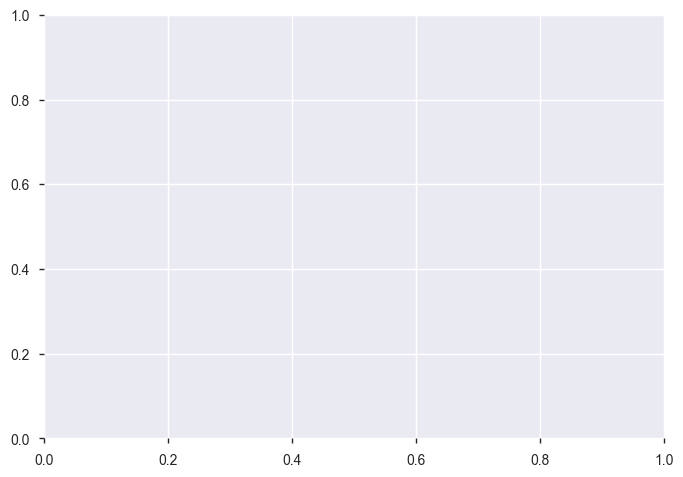

In [175]:
"""#separate by class, see feature mean
all_data_1S_0 = data[data.muestra=="A"]
all_data_1S_1 = data[data.muestra=="C"]
all_data_1S_2 = data[data.muestra=="L"]
all_data_1S_3 = data[data.muestra=="M"]
all_data_1S_4 = data[data.muestra=="0"]
all_data_1S_5 = data[data.muestra=="U"]


draw_col = 10
sns.distplot(all_data_1S_0.iloc[:,draw_col], hist=False, kde=True, color='red')
sns.distplot(all_data_1S_1.iloc[:,draw_col], hist=False, kde=True, color='green')
sns.distplot(all_data_1S_2.iloc[:,draw_col], hist=False, kde=True, color='yellow')
sns.distplot(all_data_1S_4.iloc[:,draw_col], hist=False, kde=True, color='blue')
sns.distplot(all_data_1S_5.iloc[:,draw_col], hist=False, kde=True, color='black')"""

## Metrics

#############################
X_train: (59155, 93)
X_test: (29137, 93)
y_train: (59155,)
y_test: (29137,)

 _______________________________________________________
confusion matrix: 

[[5752   17   13  546   10   18]
 [   9 3426    4  485   13   10]
 [  11   15 4937  605   11   31]
 [   8    9   10 4654   14   10]
 [  18   14    5  400 3446   10]
 [   8    5   25  391    6 4191]]

 _______________________________________________________
classification report: 

              precision    recall  f1-score   support

           A       0.99      0.90      0.95      6356
           C       0.98      0.87      0.92      3947
           L       0.99      0.88      0.93      5610
           M       0.66      0.99      0.79      4705
           O       0.98      0.89      0.93      3893
           U       0.98      0.91      0.94      4626

   micro avg       0.91      0.91      0.91     29137
   macro avg       0.93      0.91      0.91     29137
weighted avg       0.93      0.91      0.91   

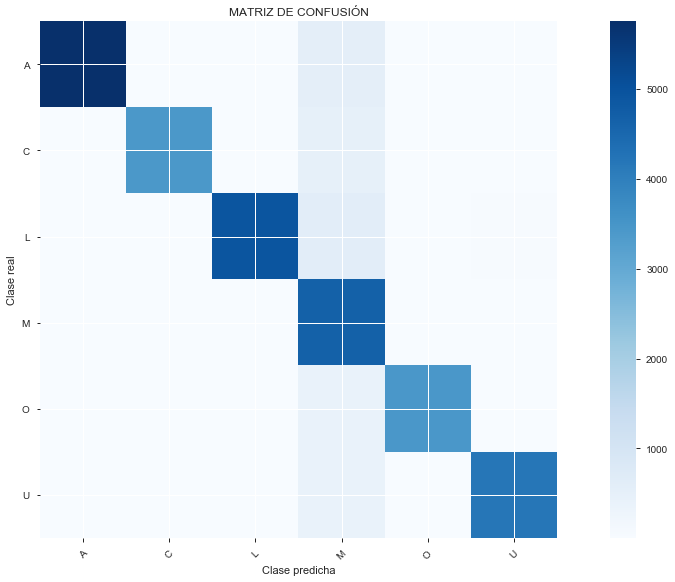

In [351]:
print("#############################")
excercise_1(all_data_1S, 50)

# Conclusions:

### According precision and recall metrics, the best answer are with method 1 , where training and test data are taken radomly, by the way the best results appear when the time analyzed is 10 seconds , probably because the activities sequence going the best results over a longer time. 

### Maybe this metric would be reduced if you take more than 10 seconds or as it`s showing in this report you can reduce the effectiveness if you take a litlle less bit time as well.

### If only one place could be selected to put the senssor according to the correlation matrix I would place it on back, which one has a highest level of correlation with other variables (related with acelerometer and innertian) an then this one can give me reliable information , but that would be useful for this analysis. 


### If the smartphone changed it´s orientation , I suposse the answers of this study doesn´t change , because the sensors of the smartphone (accelerometer, gyroscope, magnetometer), can tell you the position of the phone.